# Búsqueda Vectorial con Qdrant

## ¿Qué es la Búsqueda Vectorial?

La búsqueda vectorial es la columna vertebral del internet moderno, aunque muchas veces pase desapercibida. Impulsa motores de recomendación, chatbots, agentes de inteligencia artificial e incluso buscadores a gran escala.

En términos simples, la búsqueda tradicional por palabras clave funciona buscando coincidencias exactas. Esto es útil cuando conoces las palabras precisas que se encuentran en los datos. Pero ¿qué sucede cuando no hay palabras clave? ¿Y si estás buscando en imágenes, audio, video, código o incluso de forma cruzada entre modalidades?

Incluso en documentos llenos de texto, la búsqueda por palabras clave tiene dificultades para capturar el contexto y el significado. Una misma idea puede expresarse de muchas maneras, por lo que resulta inviable usar únicamente métodos basados en palabras clave.

En lugar de depender de coincidencias exactas, la búsqueda vectorial recupera información basándose en la **similitud semántica**, medida numéricamente entre representaciones vectorizadas de los datos (embeddings). Este enfoque reconoce patrones y relaciones entre conceptos, permitiendo que los sistemas de búsqueda encuentren contenido relevante incluso si se utiliza una redacción distinta, terminología diferente o no existen palabras clave explícitas.

## Qdrant

[Qdrant](https://qdrant.tech/) es un motor de búsqueda vectorial **open source**, una solución especializada escrita en Rust para realizar búsquedas vectoriales de forma escalable.  
Si te preguntas por qué podrías necesitar una solución dedicada para este tipo de búsqueda, puedes consultar el artículo ["Built for Vector Search"](https://qdrant.tech/articles/dedicated-vector-search/).

Resumen rápido:
- Para realizar búsquedas vectoriales a nivel de producción y con buena escalabilidad.
- Para mantenerse al día con las mejores prácticas y tendencias más recientes.
- Para aprovechar completamente las capacidades de la búsqueda vectorial (más allá de la simple búsqueda por similitud).

En este repositorio/archivo, te damos un adelanto de lo que es la búsqueda semántica con Qdrant y te animamos a experimentar con ella para ver si se ajusta a tus necesidades.

¿Tienes preguntas sobre cómo usar Qdrant para búsquedas vectoriales? Únete a nuestra [comunidad en Discord](https://discord.gg/G7PQU6Cy) y participa.


## Paso 0: Configuración

Qdrant es completamente open source, lo que significa que puedes ejecutarlo de múltiples formas según tus necesidades.  
Puedes alojarlo en tu propia infraestructura, desplegarlo en Kubernetes o ejecutarlo en la nube mediante un servicio administrado.

En este caso, vamos a ejecutar una instancia de Qdrant en un contenedor Docker.

### Docker

Todo lo que necesitas hacer es descargar la imagen y lanzar el contenedor usando los siguientes comandos:

```bash
docker pull qdrant/qdrant

docker run -p 6333:6333 -p 6334:6334 \
   -v "$(pwd)/qdrant_storage:/qdrant/storage:z" \
   qdrant/qdrant
```

La segunda línea del comando `docker run` monta un volumen de almacenamiento local para mantener tus datos persistentes.  
Esto significa que, incluso si reinicias o eliminas el contenedor, tus datos seguirán almacenados localmente.

- **Puerto 6333** – API REST  
- **Puerto 6334** – API gRPC

Para ayudarte a explorar los datos de forma visual, Qdrant incluye una **interfaz web integrada**, disponible tanto en Qdrant Cloud como en instancias locales.  
Puedes usarla para inspeccionar colecciones, verificar el estado del sistema e incluso ejecutar consultas simples.

Cuando ejecutas Qdrant en Docker, la interfaz web está disponible en:  
[http://localhost:6333/dashboard](http://localhost:6333/dashboard)

### Instalación de Librerías Requeridas

En el entorno que has creado específicamente para este curso/proyecto, instalaremos:

- El paquete `qdrant-client`. Usaremos el cliente en Python, pero Qdrant también ofrece clientes oficiales para JavaScript/TypeScript, Go y Rust, por lo que puedes elegir el que mejor se adapte a tus proyectos.

- El paquete `fastembed`: una solución optimizada para la generación de embeddings (vectorización de datos) diseñada específicamente para Qdrant.  
  Asegúrate de instalar la versión `>= 1.14.2` para poder usar la **inferencia local** junto con Qdrant.

In [ ]:
!python -m pip install -q "qdrant-client[fastembed]>=1.14.2"

## Paso 1: Importar las Librerías Necesarias y Conectarse a Qdrant

Ahora vamos a importar los módulos necesarios del paquete `qdrant-client`.

La clase `QdrantClient` nos permite establecer una conexión con el servicio de Qdrant,  
mientras que el módulo `models` proporciona las definiciones para diversas configuraciones y parámetros que utilizaremos.

In [1]:
from qdrant_client import QdrantClient, models

Inicializar el Cliente

Una vez importadas las librerías, podemos inicializar el cliente de Qdrant.  
Esto nos permitirá interactuar con la instancia local (o remota) del servicio.

In [2]:
client = QdrantClient("http://localhost", port=6333)

## Paso 2: Analizar el Conjunto de Datos

Para construir una solución funcional de búsqueda vectorial (y, en general, para entender si se necesita, cuándo y cómo),  
es fundamental analizar el conjunto de datos y comprender la naturaleza y estructura de la información con la que vamos a trabajar. Por ejemplo:

- **Modalidad** — ¿es texto, imágenes, videos o una combinación de ellos?  
- **Especificaciones** — si se trata de texto: ¿en qué idioma está?, ¿qué tan largos son los fragmentos?, ¿hay caracteres especiales?

Este análisis nos ayudará a definir:

- el **esquema de datos** adecuado (qué parte vectorizar, qué guardar como metadatos, etc.);  
- el **modelo de embedding** correcto (el que mejor se adapte al dominio, a los requisitos de precisión y a los recursos disponibles).

Contamos con un conjunto de datos de ejemplo para fines de experimentación. Vamos a explorarlo:



In [3]:
import requests

docs_url = 'https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

In [6]:
documents_raw[0].get('documents')[0:2]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?'},
 {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'section': 'General course-related questions',
  'question': 'Course - What are the prerequisites for this course?'}]

Los datos ya parecen estar limpios y segmentados (es decir, divididos en piezas pequeñas que los modelos de embeddings pueden procesar fácilmente),  
así que lo que nos queda es definir:

- qué campos se utilizarán para la **búsqueda semántica**;
- qué campos se almacenarán como **metadatos**, por ejemplo, para usarlos en condiciones de filtrado.

Contamos con un conjunto de datos que incluye tres tipos de cursos:  
`data-engineering-zoomcamp`, `machine-learning-zoomcamp` y `mlops-zoomcamp`.  
Cada curso incluye una colección de pares de `question` (pregunta) y `text` (respuesta), junto con la `section` (sección) a la que hace referencia la pregunta.

---

#### Qué Campos Podrían Usarse para la Búsqueda Semántica

Aquí podemos observar la similitud semántica en la práctica: algunas preguntas y respuestas no comparten muchas palabras en común,  
pero claramente abordan el mismo tema. Una pregunta sobre un tópico, la otra proporciona la respuesta.

Por ejemplo:

**Pregunta:**  
- *“Me he **registrado** en el Bootcamp de Ingeniería de Datos. ¿Cuándo puedo esperar recibir el correo de confirmación?”*

**Respuesta:**  
- *“No lo necesitas. Estás aceptado. También puedes comenzar a aprender y enviar tareas sin registrarte. No se verifica contra ninguna lista de **registrados**. El registro solo sirve para medir el interés antes de la fecha de inicio.”*

Estas dos oraciones podrían coincidir usando la palabra clave **registrado**,  
pero una frase como *“Los participantes no **registrados** no reciben certificación”* también coincidiría con esa palabra clave, aunque su significado semántico es diferente.

Por eso, si estamos construyendo un sistema de generación aumentada por recuperación (RAG) para preguntas y respuestas,  
tiene sentido almacenar el campo `texto` (las respuestas) como **embeddings**, y usar búsqueda vectorial para encontrar la respuesta más relevante para una `pregunta` dada.

#### Campos que deberían almacenarse como metadatos

Por ejemplo, podríamos almacenar los campos `curso` y `sección` como metadatos.  
De esta forma, podemos filtrar los resultados de búsqueda cuando se hagan preguntas relacionadas con un curso o sección específicos.


## Paso 3: Elección del Modelo de Embeddings con FastEmbed

Ahora que sabemos que vamos a generar embeddings de pequeños fragmentos de texto en inglés (pares de preguntas y respuestas relacionadas con el curso), podemos elegir un modelo de embeddings adecuado para convertir estos datos en vectores.

La elección del modelo de embeddings depende de varios factores:  
- La tarea, modalidad de datos y características específicas;  
- El balance entre precisión en la búsqueda y uso de recursos (embeddings más grandes requieren más almacenamiento y memoria);  
- El costo de inferencia (especialmente si usas un proveedor externo);  
- Entre otros.

> La mejor forma de seleccionar un modelo de embeddings es **probar y comparar distintas opciones con tus propios datos**.

En este notebook, usaremos [FastEmbed](https://github.com/qdrant/fastembed) como proveedor de embeddings.

---

**FastEmbed** es una solución optimizada de embeddings diseñada específicamente para Qdrant. Ofrece generación de embeddings con baja latencia y amigable para CPU, eliminando la necesidad de frameworks pesados como PyTorch o TensorFlow. Utiliza pesos de modelo cuantizados y ONNX Runtime, lo que la hace significativamente más rápida que los tradicionales Sentence Transformers en CPU, manteniendo una precisión competitiva.

FastEmbed soporta:  
- **Embeddings densos** para texto e imágenes (*el tipo más común en búsqueda vectorial, que usaremos hoy*).  
- **Embeddings dispersos** (por ejemplo, BM25 y embeddings neuronales dispersos).  
- **Embeddings multivector** (por ejemplo, ColPali y ColBERT, modelos de interacción tardía).  
- **Rerankers**.

Todos estos tipos pueden usarse directamente en Qdrant (ya que **Qdrant soporta embeddings densos, dispersos y multivectoriales junto con búsqueda híbrida**).  
La integración de FastEmbed con Qdrant permite pasar directamente texto o imágenes al cliente Qdrant para generar embeddings.

En este notebook, usaremos FastEmbed para inferencia local con Qdrant.  
> Ten en cuenta los recursos de tu máquina al elegir un modelo de embeddings para inferencia local.


### FastEmbed para Datos Textuales

Vamos a seleccionar un modelo de embeddings para usar con las preguntas y respuestas del curso, almacenadas en campos `text`, entre las opciones que soporta FastEmbed.


In [14]:
from fastembed import TextEmbedding
TextEmbedding.list_supported_models()

[{'model': 'BAAI/bge-base-en',
  'sources': {'hf': 'Qdrant/fast-bge-base-en',
   'url': 'https://storage.googleapis.com/qdrant-fastembed/fast-bge-base-en.tar.gz',
   '_deprecated_tar_struct': True},
  'model_file': 'model_optimized.onnx',
  'description': 'Text embeddings, Unimodal (text), English, 512 input tokens truncation, Prefixes for queries/documents: necessary, 2023 year.',
  'license': 'mit',
  'size_in_GB': 0.42,
  'additional_files': [],
  'dim': 768,
  'tasks': {}},
 {'model': 'BAAI/bge-base-en-v1.5',
  'sources': {'hf': 'qdrant/bge-base-en-v1.5-onnx-q',
   'url': 'https://storage.googleapis.com/qdrant-fastembed/fast-bge-base-en-v1.5.tar.gz',
   '_deprecated_tar_struct': True},
  'model_file': 'model_optimized.onnx',
  'description': 'Text embeddings, Unimodal (text), English, 512 input tokens truncation, Prefixes for queries/documents: not so necessary, 2023 year.',
  'license': 'mit',
  'size_in_GB': 0.21,
  'additional_files': [],
  'dim': 768,
  'tasks': {}},
 {'model':

Tiene sentido elegir un modelo que produzca embeddings de tamaño pequeño a moderado (por ejemplo, 512 dimensiones), para no sobrecargar los recursos en nuestra configuración sencilla.

In [8]:
import json

EMBEDDING_DIMENSIONALITY = 512

for model in TextEmbedding.list_supported_models():
    if model["dim"] == EMBEDDING_DIMENSIONALITY:
        print(json.dumps(model, indent=2))

{
  "model": "BAAI/bge-small-zh-v1.5",
  "sources": {
    "hf": "Qdrant/bge-small-zh-v1.5",
    "url": "https://storage.googleapis.com/qdrant-fastembed/fast-bge-small-zh-v1.5.tar.gz",
    "_deprecated_tar_struct": true
  },
  "model_file": "model_optimized.onnx",
  "description": "Text embeddings, Unimodal (text), Chinese, 512 input tokens truncation, Prefixes for queries/documents: not so necessary, 2023 year.",
  "license": "mit",
  "size_in_GB": 0.09,
  "additional_files": [],
  "dim": 512,
  "tasks": {}
}
{
  "model": "Qdrant/clip-ViT-B-32-text",
  "sources": {
    "hf": "Qdrant/clip-ViT-B-32-text",
    "url": null,
    "_deprecated_tar_struct": false
  },
  "model_file": "model.onnx",
  "description": "Text embeddings, Multimodal (text&image), English, 77 input tokens truncation, Prefixes for queries/documents: not necessary, 2021 year",
  "license": "mit",
  "size_in_GB": 0.25,
  "additional_files": [],
  "dim": 512,
  "tasks": {}
}
{
  "model": "jinaai/jina-embeddings-v2-small-e

Necesitamos un modelo de embeddings adecuado para **texto en inglés**.

También es conveniente seleccionar un modelo **unimodal**, ya que no incluimos imágenes en nuestra búsqueda, y las soluciones específicas suelen ser mejores que las universales.

¡Parece que `jina-embedding-small-en` es una buena opción!

In [9]:
model_handle = "jinaai/jina-embeddings-v2-small-en"

Como la mayoría de los modelos de embeddings densos, `jina-embedding-small-en` fue entrenado para medir la cercanía semántica usando **similitud coseno**.  
Esta información se puede encontrar, por ejemplo, en la [página del modelo en Hugging Face](https://huggingface.co/jinaai/jina-embeddings-v2-small-en).

> Los parámetros del modelo de embeddings elegido, incluyendo la dimensión de salida de los embeddings y la métrica de similitud (o distancia) semántica, son necesarios para configurar la búsqueda semántica en Qdrant.


Ahora estamos listos para configurar y usar Qdrant para realizar búsqueda semántica.  
Para comprender completamente lo que está ocurriendo, aquí tienes una breve descripción de la terminología central de Qdrant:

- **Puntos (Points)** son la entidad principal con la que trabaja Qdrant.  
  Un punto es un registro que consiste en un **ID**, un **vector** y un **payload** (carga útil) opcional.

- Una **colección (Collection)** es un conjunto con nombre de puntos (es decir, vectores con cargas útiles opcionales) sobre el cual puedes realizar búsquedas.  
  *Piénsalo como el contenedor de tu solución de búsqueda vectorial, que resuelve un único problema de negocio.*

> Qdrant admite distintos tipos de vectores para habilitar diferentes formas de exploración y búsqueda de datos (vectores densos, dispersos, multivectoriales y vectores nombrados).

En este ejemplo, usaremos el tipo más común: **vectores densos**.

Los embeddings capturan la esencia semántica de los datos, mientras que el **payload** contiene metadatos estructurados.  
Estos metadatos resultan especialmente útiles al aplicar filtros o al ordenar los resultados durante la búsqueda.  
**Los payloads de Qdrant** pueden contener datos estructurados como booleanos, palabras clave, ubicaciones geográficas, arreglos y objetos anidados.


## Paso 4: Crear una Colección

Al crear una [colección](https://qdrant.tech/documentation/concepts/collections/), necesitamos especificar:

* **Nombre**: Un identificador único para la colección.  
* **Configuración del vector**:  
  * **Tamaño**: La dimensionalidad de los vectores.  
  * **Métrica de distancia**: El método usado para medir la similitud entre vectores.

Hay parámetros adicionales que puedes explorar en la [documentación oficial](https://qdrant.tech/documentation/concepts/collections/#create-a-collection).  

Además, en Qdrant se pueden configurar otros tipos de vectores más allá de los embeddings densos típicos (por ejemplo, para búsqueda híbrida).  
Sin embargo, para este ejemplo, la configuración predeterminada más simple es suficiente.

    

In [11]:
# Define the collection name
collection_name = "zoomcamp-rag"

# Create the collection with specified vector parameters
client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,  # Dimensionality of the vectors
        distance=models.Distance.COSINE  # Distance metric for similarity search
    )
)

True

## Paso 5: Crear, Generar Embeddings e Insertar Puntos en la Colección

Los [puntos](https://qdrant.tech/documentation/concepts/points/#points) son las entidades de datos centrales en Qdrant. Cada punto está compuesto por:

1. **ID**: Un identificador único. Qdrant admite tanto enteros sin signo de 64 bits como UUIDs.  
2. **Vector**: El embedding que representa el punto de datos en el espacio vectorial.  
3. **Payload** *(opcional)*: Metadatos adicionales en forma de pares clave-valor.

In [12]:
points = []
id = 0

for course in documents_raw:
    for doc in course['documents']:

        point = models.PointStruct(
            id=id,
            vector=models.Document(text=doc['text'], model=model_handle), #embed text locally with "jinaai/jina-embeddings-v2-small-en" from FastEmbed
            payload={
                "text": doc['text'],
                "section": doc['section'],
                "course": course['course']
            } #save all needed metadata fields
        )
        points.append(point)

        id += 1

Ahora vamos a generar embeddings y subir los puntos a nuestra colección.

Primero, FastEmbed descargará el modelo seleccionado (la ruta por defecto es `os.path.join(tempfile.gettempdir(), "fastembed_cache")`) y realizará la inferencia directamente en tu máquina.  
Luego, los puntos generados se insertarán (upsert) en la colección, y se construirá el índice vectorial.

In [13]:
client.upsert(
    collection_name=collection_name,
    points=points
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/130M [00:00<?, ?B/s]

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

La velocidad del *upsert* depende principalmente del tiempo que lleva la inferencia local.  
Para acelerar este proceso, podrías ejecutar FastEmbed en GPUs o usar una máquina con más recursos.

Además del `upsert` básico, Qdrant admite **upsert por lotes** tanto en formato orientado a columnas como a registros.

El cliente de Python ofrece funcionalidades como:
- Paralelización  
- Reintentos automáticos  
- Agrupamiento por lotes de forma perezosa (*lazy batching*)

Estas opciones pueden configurarse mediante parámetros en las funciones `upload_collection` y `upload_points`.  
Para más detalles, consulta la [documentación oficial](https://qdrant.tech/documentation/concepts/points/#upload-points).



### Explorar los Datos de Forma Visual

Vamos a explorar los datos subidos desde la interfaz web de Qdrant en [http://localhost:6333/dashboard](http://localhost:6333/dashboard) para estudiar la similitud semántica de forma visual.

Por ejemplo, usando la pestaña `Visualize` dentro de la colección `zoomcamp-rag`, podemos ver todas las respuestas a las preguntas del curso (948 puntos) y observar cómo se agrupan según su significado, además de estar coloreadas según el tipo de curso.

Para hacerlo, ejecuta el siguiente comando:

```json
{
  "limit": 948,
  "color_by": {
    "payload": "course"
  }
}
```

Esta representación en 2D es el resultado de aplicar reducción de dimensionalidad a los `jina-embeddings`.

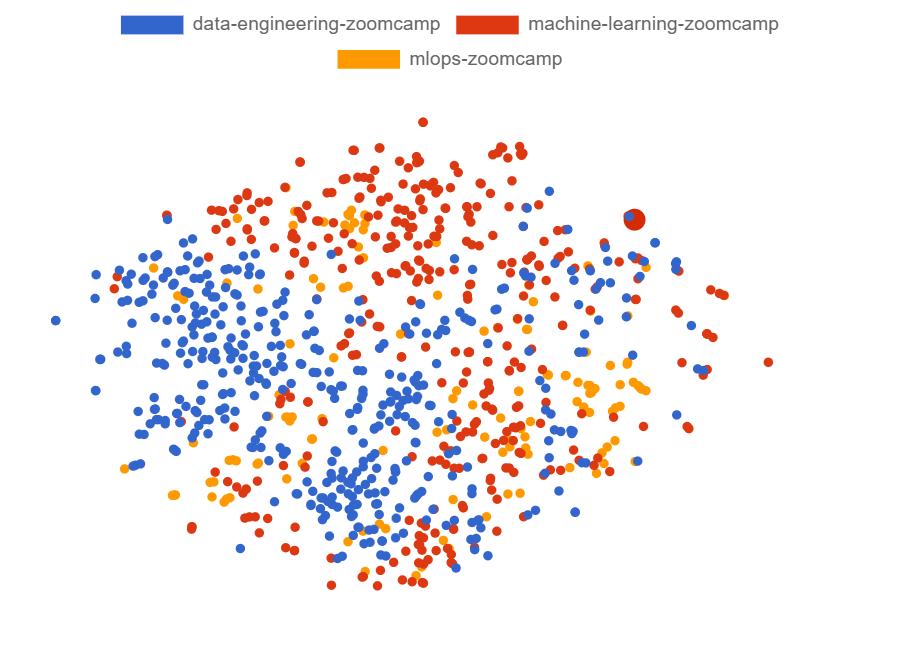


```json
{
  "limit": 948,
  "color_by": {
    "payload": "course"
  }
}
```

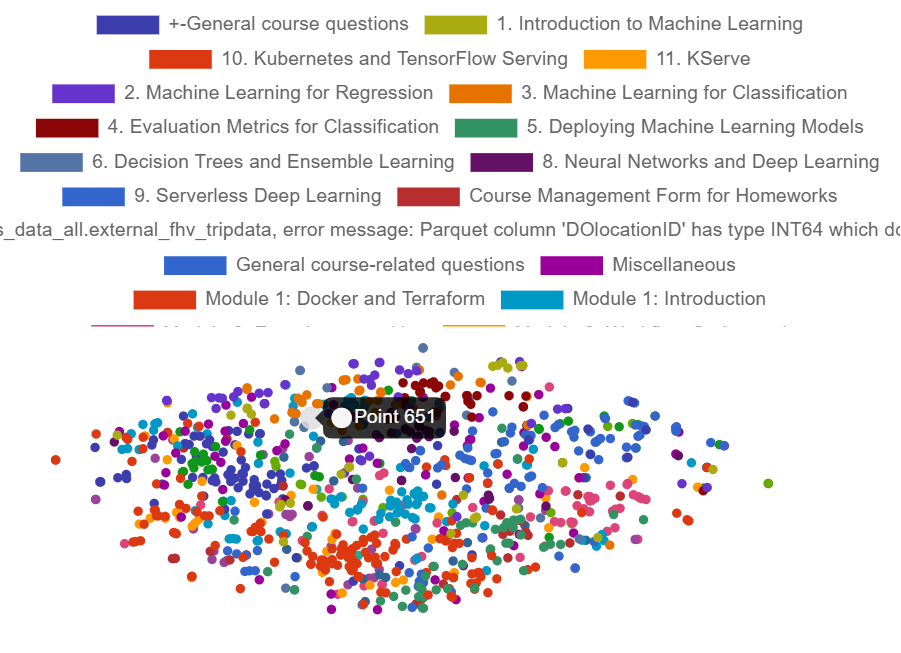



## Paso 6: Ejecutar una Búsqueda por Similitud

Ahora vamos a buscar en Qdrant el vector `text` más similar a un embedding de consulta, es decir, la respuesta más relevante para una pregunta dada.

### Cómo Funciona la Búsqueda por Similitud

1. Qdrant compara el vector de consulta con los vectores almacenados (basándose en un índice vectorial) utilizando la métrica de distancia definida al crear la colección.

2. Se devuelven las coincidencias más cercanas, ordenadas por similitud.

> El índice vectorial está construido para realizar búsquedas de **vecinos más cercanos aproximados** (ANN), lo que permite búsquedas vectoriales a gran escala de forma eficiente.

Si quieres profundizar en nuestra elección de índice vectorial para la búsqueda, puedes consultar nuestro artículo ["¿Qué es una base de datos vectorial?"](https://qdrant.tech/articles/what-is-a-vector-database/), o, si buscas una explicación más técnica, nuestro artículo sobre [Filterable Hierarchical Navigable Small World](https://qdrant.tech/articles/filtrable-hnsw/).

Definamos una función de búsqueda:

In [16]:
def search(query, limit=1):

    results = client.query_points(
        collection_name=collection_name,
        query=models.Document( #embed the query text locally with "jinaai/jina-embeddings-v2-small-en"
            text=query,
            model=model_handle 
        ),
        limit=limit, # top closest matches
        with_payload=True #to get metadata in the results
    )

    return results

Ahora vamos a elegir una pregunta aleatoria del conjunto de datos del curso.  
Como recordarás, no subimos las preguntas a Qdrant.

In [17]:
import random

course = random.choice(documents_raw)
course_piece = random.choice(course['documents'])
print(json.dumps(course_piece, indent=2))

{
  "text": "Run this before SparkSession\nimport os\nimport sys\nos.environ['PYSPARK_PYTHON'] = sys.executable\nos.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable",
  "section": "Module 5: pyspark",
  "question": "Py4JJavaError: An error occurred while calling o180.showString. : org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6.0 (TID 6) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back."
}


Veamos qué respuesta obtenemos:

In [40]:
result = search(course_piece['question'])

In [41]:
result

QueryResponse(points=[ScoredPoint(id=384, version=0, score=0.8941189, payload={'text': 'While following tutorial 13.2 , when running ./spark-submit.sh streaming.py, encountered the following error:\n…\n24/03/11 09:48:36 INFO StandaloneAppClient$ClientEndpoint: Connecting to master spark://localhost:7077...\n24/03/11 09:48:36 INFO TransportClientFactory: Successfully created connection to localhost/127.0.0.1:7077 after 10 ms (0 ms spent in bootstraps)\n24/03/11 09:48:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors\n24/03/11 09:48:56 INFO StandaloneAppClient$ClientEndpoint: Connecting to master spark://localhost:7077…\n24/03/11 09:49:16 INFO StandaloneAppClient$ClientEndpoint: Connecting to master spark://localhost:7077...\n24/03/11 09:49:36 WARN StandaloneSchedulerBackend: Application

`score` – la similitud coseno entre los embeddings de la `question` y el `text`.


In [33]:
type(result)

qdrant_client.http.models.models.QueryResponse

Compararemos la respuesta original con la respuesta recuperada para nuestra pregunta seleccionada al azar.

In [42]:
print(f"Question:\n{course_piece['question']}\n")

print("Top Retrieved Answer:\n{}\n".format(result.points[0].payload['text']))

print("Original Answer:\n{}".format(course_piece['text']))


Question:
Py4JJavaError: An error occurred while calling o180.showString. : org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6.0 (TID 6) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker failed to connect back.

Top Retrieved Answer:
While following tutorial 13.2 , when running ./spark-submit.sh streaming.py, encountered the following error:
…
24/03/11 09:48:36 INFO StandaloneAppClient$ClientEndpoint: Connecting to master spark://localhost:7077...
24/03/11 09:48:36 INFO TransportClientFactory: Successfully created connection to localhost/127.0.0.1:7077 after 10 ms (0 ms spent in bootstraps)
24/03/11 09:48:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollector

Ahora busquemos la respuesta a una pregunta que no estaba en el conjunto de datos inicial.

In [43]:
print(search("What if I submit homeworks late?").points[0].payload['text'])

No, late submissions are not allowed. But if the form is still not closed and it’s after the due date, you can still submit the homework. confirm your submission by the date-timestamp on the Course page.y
Older news:[source1] [source2]


## Paso 7: Ejecutar una Búsqueda por Similitud con Filtros

Podemos refinar nuestra búsqueda utilizando filtros basados en metadatos.

> La implementación personalizada del índice vectorial de Qdrant, Filterable HNSW, permite realizar búsquedas vectoriales precisas y escalables con condiciones de filtrado.

Por ejemplo, podemos buscar la respuesta a una pregunta relacionada con un curso específico de los tres disponibles en el conjunto de datos.  
Usar un filtro `must` asegura que todas las condiciones especificadas se cumplan para que un punto de datos sea incluido en los resultados.

> Qdrant también soporta otros tipos de filtros como `should`, `must_not`, `range` y más. Para una visión completa, consulta nuestra [Guía de Filtrado](https://qdrant.tech/articles/vector-search-filtering/).


Para habilitar un filtrado eficiente, necesitamos activar el [indexado de los campos del payload](https://qdrant.tech/documentation/concepts/indexing/#payload-index).

In [44]:
client.create_payload_index(
    collection_name=collection_name,
    field_name="course",
    field_schema="keyword" # exact matching on string metadata fields
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

Ahora vamos a actualizar nuestra función de búsqueda.

In [45]:
def search_in_course(query, course="mlops-zoomcamp", limit=1):

    results = client.query_points(
        collection_name=collection_name,
        query=models.Document( #embed the query text locally with "jinaai/jina-embeddings-v2-small-en"
            text=query,
            model=model_handle
        ),
        query_filter=models.Filter( # filter by course name
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=limit, # top closest matches
        with_payload=True #to get metadata in the results
    )

    return results

Veamos cómo se responde la misma pregunta en diferentes cursos:  
`data-engineering-zoomcamp`, `machine-learning-zoomcamp` y `mlops-zoomcamp`.


In [47]:
print(search_in_course("What if I submit homeworks late?", "mlops-zoomcamp").points[0].payload['text'])

Please choose the closest one to your answer. Also do not post your answer in the course slack channel.


## Ejemplo 2

In [77]:
import random

# Listas base
docs_base = [
    "Qdrant has a LangChain integration for chatbots.",
    "Qdrant has a LlamaIndex integration for agents.",
    "Qdrant supports hybrid search combining keyword and vector search.",
    "You can use Qdrant as a vector store in LangChain pipelines.",
    "LlamaIndex uses Qdrant to persist semantic documents efficiently.",
    "Qdrant provides high performance vector search for AI applications.",
    "Qdrant can filter search results using structured metadata.",
    "LangChain uses Qdrant to retrieve context for language models.",
    "With Qdrant, RAG pipelines become faster and more scalable.",
    "Qdrant integrates easily with Python and popular ML frameworks.",
]

metadata_base = [
    {"source": "langchain-docs"},
    {"source": "llamaindex-docs"},
    {"source": "qdrant-docs"},
    {"source": "langchain-examples"},
    {"source": "llamaindex-tutorials"},
    {"source": "qdrant-blog"},
    {"source": "qdrant-api"},
    {"source": "langchain-rag"},
    {"source": "rag-resources"},
    {"source": "ml-integration-guides"},
]

ids_base = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110]

# Generar 100 elementos con ligeras alteraciones
docs = []
metadata = []
ids = []

for i in range(1000):
    base_index = i % 2
    doc_variation = docs_base[base_index].replace("Qdrant", random.choice(["Qdrant", "The Qdrant engine"]))
    doc_variation = doc_variation.replace("chatbots", random.choice(["chatbots", "virtual assistants", "AI agents"]))
    doc_variation = doc_variation.replace("agents", random.choice(["agents", "tools", "workflows"]))
    
    docs.append(doc_variation)
    metadata.append(metadata_base[base_index])
    ids.append(i + 1)  # IDs únicos del 1 al 100

In [71]:
model_name = "BAAI/bge-small-en"

client.create_collection(
    collection_name="documentos_varios",
    vectors_config=models.VectorParams(
        size=client.get_embedding_size(model_name), 
        distance=models.Distance.COSINE
    ),  # size and distance are model dependent
)

ResponseHandlingException: timed out

In [78]:
metadata_with_docs = [{"document": doc, "source": meta["source"]} for doc, meta in zip(docs, metadata)]
list_vectors = [models.Document(text=doc, model=model_name) for doc in docs]

In [79]:
list_vectors[0]

Document(text='Qdrant has a LangChain integration for chatbots.', model='BAAI/bge-small-en', options=None)

In [80]:
client.upload_collection(
    collection_name="documentos_varios",
    vectors=list_vectors,
    payload=metadata_with_docs,
    ids=ids
)

In [81]:
search_result = client.query_points(
    collection_name="documentos_varios",
    query=models.Document(
        text="Which integration is best for agents?", 
        model=model_name
    )
).points
print(search_result)

[ScoredPoint(id=2, version=2, score=0.874918, payload={'document': 'Qdrant has a LlamaIndex integration for agents.', 'source': 'llamaindex-docs'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=38, version=2, score=0.874918, payload={'document': 'Qdrant has a LlamaIndex integration for agents.', 'source': 'llamaindex-docs'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=56, version=2, score=0.874918, payload={'document': 'Qdrant has a LlamaIndex integration for agents.', 'source': 'llamaindex-docs'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=28, version=2, score=0.874918, payload={'document': 'Qdrant has a LlamaIndex integration for agents.', 'source': 'llamaindex-docs'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=34, version=2, score=0.874918, payload={'document': 'Qdrant has a LlamaIndex integration for agents.', 'source': 'llamaindex-docs'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=36, v

In [82]:
[(result.id, result.score, result.payload.get('document')) for result in search_result]

[(2, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (38, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (56, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (28, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (34, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (36, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (58, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (22, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (590, 0.874918, 'Qdrant has a LlamaIndex integration for agents.'),
 (626, 0.874918, 'Qdrant has a LlamaIndex integration for agents.')]

## Ejemplo 3

In [12]:
from qdrant_client import QdrantClient, models

# Inicializar el cliente para conectarse a la instancia local de Qdrant
client = QdrantClient(url="http://localhost:6333")

# Definir el nombre de nuestra colección
collection_name = "productos_alimenticios"

# Verificar si la colección ya existe
if client.collection_exists(collection_name):
    client.delete_collection(collection_name)

# Crear la colección.
# Esto conecta directamente con los conceptos de la sección anterior.
client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=512,  # La dimensionalidad del modelo 'jinaai/jina-embeddings-v2-small-en'
        distance=models.Distance.COSINE  # Métrica de Coseno, ideal para texto
    ),
    timeout=60
)
print(f"Colección '{collection_name}' creada exitosamente.")

Colección 'productos_alimenticios' creada exitosamente.


In [13]:
import requests
from fastembed import TextEmbedding

# Descargar json de 100 documentos de productos alimenticios
docs_url = 'https://drive.usercontent.google.com/u/0/uc?id=14b6NA_xMySBAj5kTYD-X9PJWcObmOsd_&export=download'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

# Creamos lista con el texto a utilizarce para crear los vectores
list_docs = [ f"{doc['nombre']} {doc['descripcion']}" for doc in documents_raw]

# Utilizar el modelo para crear los vectores
model_embedding = "jinaai/jina-embeddings-v2-small-en"
embedding_model = TextEmbedding(model_name=model_embedding)
result_embed = list(embedding_model.embed(list_docs))    

result_embed[0].shape

(512,)

In [14]:
from qdrant_client.models import PointStruct

# Preparar los payloads (metadatos) para cada documento.
list_payloads = [{'nombre': doc['nombre'], 
              'descripcion': doc['descripcion'],
              'informacion_nutricional': doc['informacion_nutricional'],
              'precio': doc['precio'],
              'marca': doc['marca'],
              'pais_procedencia': doc['pais_procedencia']
            }
            for doc in documents_raw]

# Preparar los ids para cada documento.
list_ids = [doc['id'] for doc in documents_raw]

# Crear una lista de PointStruct individualmente
points = [
    PointStruct(
        id=id_v,
        vector=vector_v,
        payload=payload_v
    )
    for id_v, vector_v, payload_v in zip(list_ids, result_embed, list_payloads)
]

# Utilizar upsert
client.upsert(
    collection_name=collection_name,
    points=points,
    wait=True
)

print(f"{len(points)} puntos insertados en la colección usando 'upsert'.")

100 puntos insertados en la colección usando 'upsert'.


In [16]:
# Preparar los payloads (metadatos) para cada documento.
list_payloads = [{'nombre': doc['nombre'], 
              'descripcion': doc['descripcion'],
              'informacion_nutricional': doc['informacion_nutricional'],
              'precio': doc['precio'],
              'marca': doc['marca'],
              'pais_procedencia': doc['pais_procedencia']
            }
            for doc in documents_raw]

# Preparar los ids para cada documento.
list_ids = [doc['id'] for doc in documents_raw]

# upload_collection utiliza un enfoque "orientado a columnas".
client.upload_collection(
    collection_name=collection_name,
    vectors=result_embed,
    payload=list_payloads,
    ids=list_ids,
    batch_size=50,  # Controla cuántos puntos se envían en cada petición de red.
    parallel=2 # Número de hilos para procesar la carga.
)
print(f"{len(result_embed)} puntos insertados en la colección usando 'upload_collection'.")

100 puntos insertados en la colección usando 'upload_collection'.


### Diferencias entre `upload_collection()` y `upsert()` en Qdrant

| Característica                        | `upload_collection()`                                                                                     | `upsert()`                                                                 |
|--------------------------------------|------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Tipo de entrada**               | Acepta vectores, payloads e IDs por separado (`vectors=`, `payload=`, `ids=`).                            | Acepta una lista de objetos `PointStruct` que combinan ID, vector y payload.|
| **Automatización del batching**   | ✅ Realiza particionamiento automático con el parámetro `batch_size=`.                                    | ❌ El batching debe ser implementado manualmente.                          |
| **Paralelización**                | ✅ Soporta ejecución paralela mediante el parámetro `parallel=`.                                          | ❌ No tiene soporte interno para paralelización.                            |
| **Manejo de reintentos**          | ✅ Incluye reintentos automáticos ante fallos transitorios.                                               | ❌ No maneja reintentos de forma automática.                               |
| **Espera hasta indexado (`wait`)**| No requiere, se gestiona internamente.                                                                    | ✅ Se puede especificar con `wait=True` para esperar la indexación.        |
| **Ideal para**                    | 🚀 Cargas grandes o iniciales (bulk insert), con optimización de rendimiento.                             | 🧱 Inserciones puntuales o controladas por el usuario (ej. actualizaciones).|

---


## Ejemplo 4

## Conclusión

🎉 ¡Felicidades! Ahora tienes todo lo necesario para ejecutar una búsqueda semántica sencilla con Qdrant. 👏

En general, la preparación, organización y almacenamiento de datos en una solución de búsqueda vectorial lista para producción es un tema que podría merecer un curso completo.  
Si tienes curiosidad por profundizar en la configuración eficiente de búsqueda vectorial, revisa nuestros [Manuales de Búsqueda Vectorial](https://qdrant.tech/articles/vector-search-manuals/).

En los próximos videos, te mostraremos cómo usar la **[búsqueda híbrida](https://qdrant.tech/articles/hybrid-search/)**, combinando las fortalezas de la búsqueda basada en palabras clave y la búsqueda vectorial. En muchas aplicaciones reales, trabajan en conjunto, equilibrando la precisión de las palabras clave con la flexibilidad de los embeddings para ofrecer los mejores resultados.

P.D. Te invitamos a explorar las capacidades de Qdrant, que van más allá de la búsqueda por similitud, impulsando pipelines RAG y agentes inteligentes (pero, mientras tanto, aquí tienes nuestro [servidor MCP](https://github.com/qdrant/mcp-server-qdrant) ;) ).
